# Exploring and Classifying Genres in Music

#### Authors (alphabetically): Aditya Kanthale, Amanuel Odicho, Vivek Patel<br/>

In addition to our final report, we have highlighted some of our work in this notebook. The notebook is in chronological order following our report, and under each section we have provided descriptions that explain our code and intentions. The code might be a little dense, thus we supplemented with some in-line comments to make it more readable. <br/>

A more elaborate description in our report can be found here:  [final-report.pdf](https://github.com/stoic-devv/spotify-data-science/blob/data-cleaning/docs/final-project.pdf) <br/>
The code for our project can be found here: [spotify-data-science](https://github.com/stoic-devv/spotify-data-science)<br/>
Dataset can be downloaded from here directly: [data](https://github.com/stoic-devv/spotify-data-science/blob/main/data/final-data.csv)<br/>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns 
from collections import defaultdict
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 42

## Data Extraction

For brevity, we have not included our code for data extraction in this notebook.
Here are some notebooks from our repository:
1. For extracting data from RateYourMusic: [album-data-rym.ipynb](https://github.com/stoic-devv/spotify-data-science/blob/main/code/album-data-rym.ipynb)
2. Scraper code and library used: [rym_charts.py](https://github.com/stoic-devv/spotify-data-science/blob/main/code/rym_charts.py), [rymscraper](https://github.com/stoic-devv/spotify-data-science/blob/main/code/lib/rymscraper/)
3. Extracting song data from Spotify: [song-data-extraction.ipynb](https://github.com/stoic-devv/spotify-data-science/blob/main/code/song-data-extraction.ipynb)
4. Merging RYM and Spotify data: [merge-data.ipynb](https://github.com/stoic-devv/spotify-data-science/blob/main/code/merge-data.ipynb)


## Dataset and cleaning

In [3]:
df = pd.read_csv('../data/final-data.csv', sep='~')
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,...,album,date,rym rating,ratings,reviews,name,popularity,rym_genres,sp_genres,genre
0,0,0,6970,0.526,0.235,7,-14.074,0,0.0991,0.907,...,"""Al final de este viaje...""",1978-04-27,3.92,1673.0,33.0,Ojalá,68,Nueva trova,"['cantautor', 'latin alternative', 'nueva canc...",NF
1,1,1,6974,0.571,0.134,0,-14.650,1,0.0704,0.895,...,"""Al final de este viaje...""",1978-04-27,3.92,1673.0,33.0,Óleo de Mujer Con Sombrero,62,Nueva trova,"['cantautor', 'latin alternative', 'nueva canc...",NF
2,2,2,6968,0.562,0.213,8,-12.273,1,0.0841,0.876,...,"""Al final de este viaje...""",1978-04-27,3.92,1673.0,33.0,Canción Del Elegido,55,Nueva trova,"['cantautor', 'latin alternative', 'nueva canc...",NF
3,3,3,6977,0.504,0.261,9,-12.577,1,0.0620,0.794,...,"""Al final de este viaje...""",1978-04-27,3.92,1673.0,33.0,Al Final de Este Viaje en la Vida,52,Nueva trova,"['cantautor', 'latin alternative', 'nueva canc...",NF
4,4,4,6969,0.682,0.236,6,-11.647,0,0.2490,0.844,...,"""Al final de este viaje...""",1978-04-27,3.92,1673.0,33.0,"La Familia, la Propiedad Privada y el Amor",50,Nueva trova,"['cantautor', 'latin alternative', 'nueva canc...",NF


In [4]:
# Columns and their (sort-of) description
drop_cols = ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0']
audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','type']
meta_data_features = ['id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'name', 'album', 'date']
user_rating_features = ['rym rating', 'ratings', 'reviews']
labels = ['popularity', 'rym_genres', 'sp_genres'] # depending on problem statement

In [5]:
df = df.drop(drop_cols, axis=1)

In [32]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'album', 'date', 'rym rating', 'ratings', 'reviews',
       'name', 'popularity', 'rym_genres', 'sp_genres'],
      dtype='object')

In [10]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,rym rating,ratings,reviews,popularity
count,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7.252000e+03,7252.000000,7252.000000,6972.00000,6972.000000,7252.000000
mean,0.453320,0.521675,5.230971,-12.092938,0.628378,0.078403,0.416099,0.288986,0.187424,0.423436,116.587878,3.070066e+05,3.841975,3.890232,7550.44148,132.534423,35.110866
std,0.188403,0.290922,3.516420,6.450656,0.483271,0.103382,0.376112,0.368500,0.153149,0.269500,29.705730,2.103129e+05,0.498917,0.103352,9199.56536,174.816432,19.173895
min,0.000000,0.000020,0.000000,-45.243000,0.000000,0.000000,0.000000,0.000000,0.015300,0.000000,0.000000,3.109600e+04,0.000000,3.650000,20.00000,1.000000,0.000000
25%,0.311000,0.276000,2.000000,-15.054250,0.000000,0.035400,0.029075,0.000047,0.095700,0.188000,94.005250,1.937262e+05,4.000000,3.820000,1295.00000,19.000000,22.000000
50%,0.450000,0.533500,5.000000,-10.552500,1.000000,0.044200,0.330000,0.024450,0.125000,0.402000,114.142000,2.559330e+05,4.000000,3.870000,4554.00000,76.000000,36.000000
75%,0.585000,0.773000,8.000000,-7.461500,1.000000,0.070400,0.815000,0.699000,0.228000,0.641000,135.107750,3.505030e+05,4.000000,3.940000,10074.00000,169.000000,49.000000
max,0.967000,1.000000,11.000000,3.744000,1.000000,0.962000,0.996000,1.000000,0.984000,0.984000,222.605000,3.682333e+06,5.000000,4.410000,74911.00000,1559.000000,87.000000


We have handled most of the `NaN` values while data-extraction itself. Due to abundance of data we skipped whichever song had missing values. 
Ratings has some missing values of about 4%. We choose to handle this later once we start building the model as we need to evaluate our assumptions of whether approximating/dropping yeilds better results

## Preparing dataset and EDA

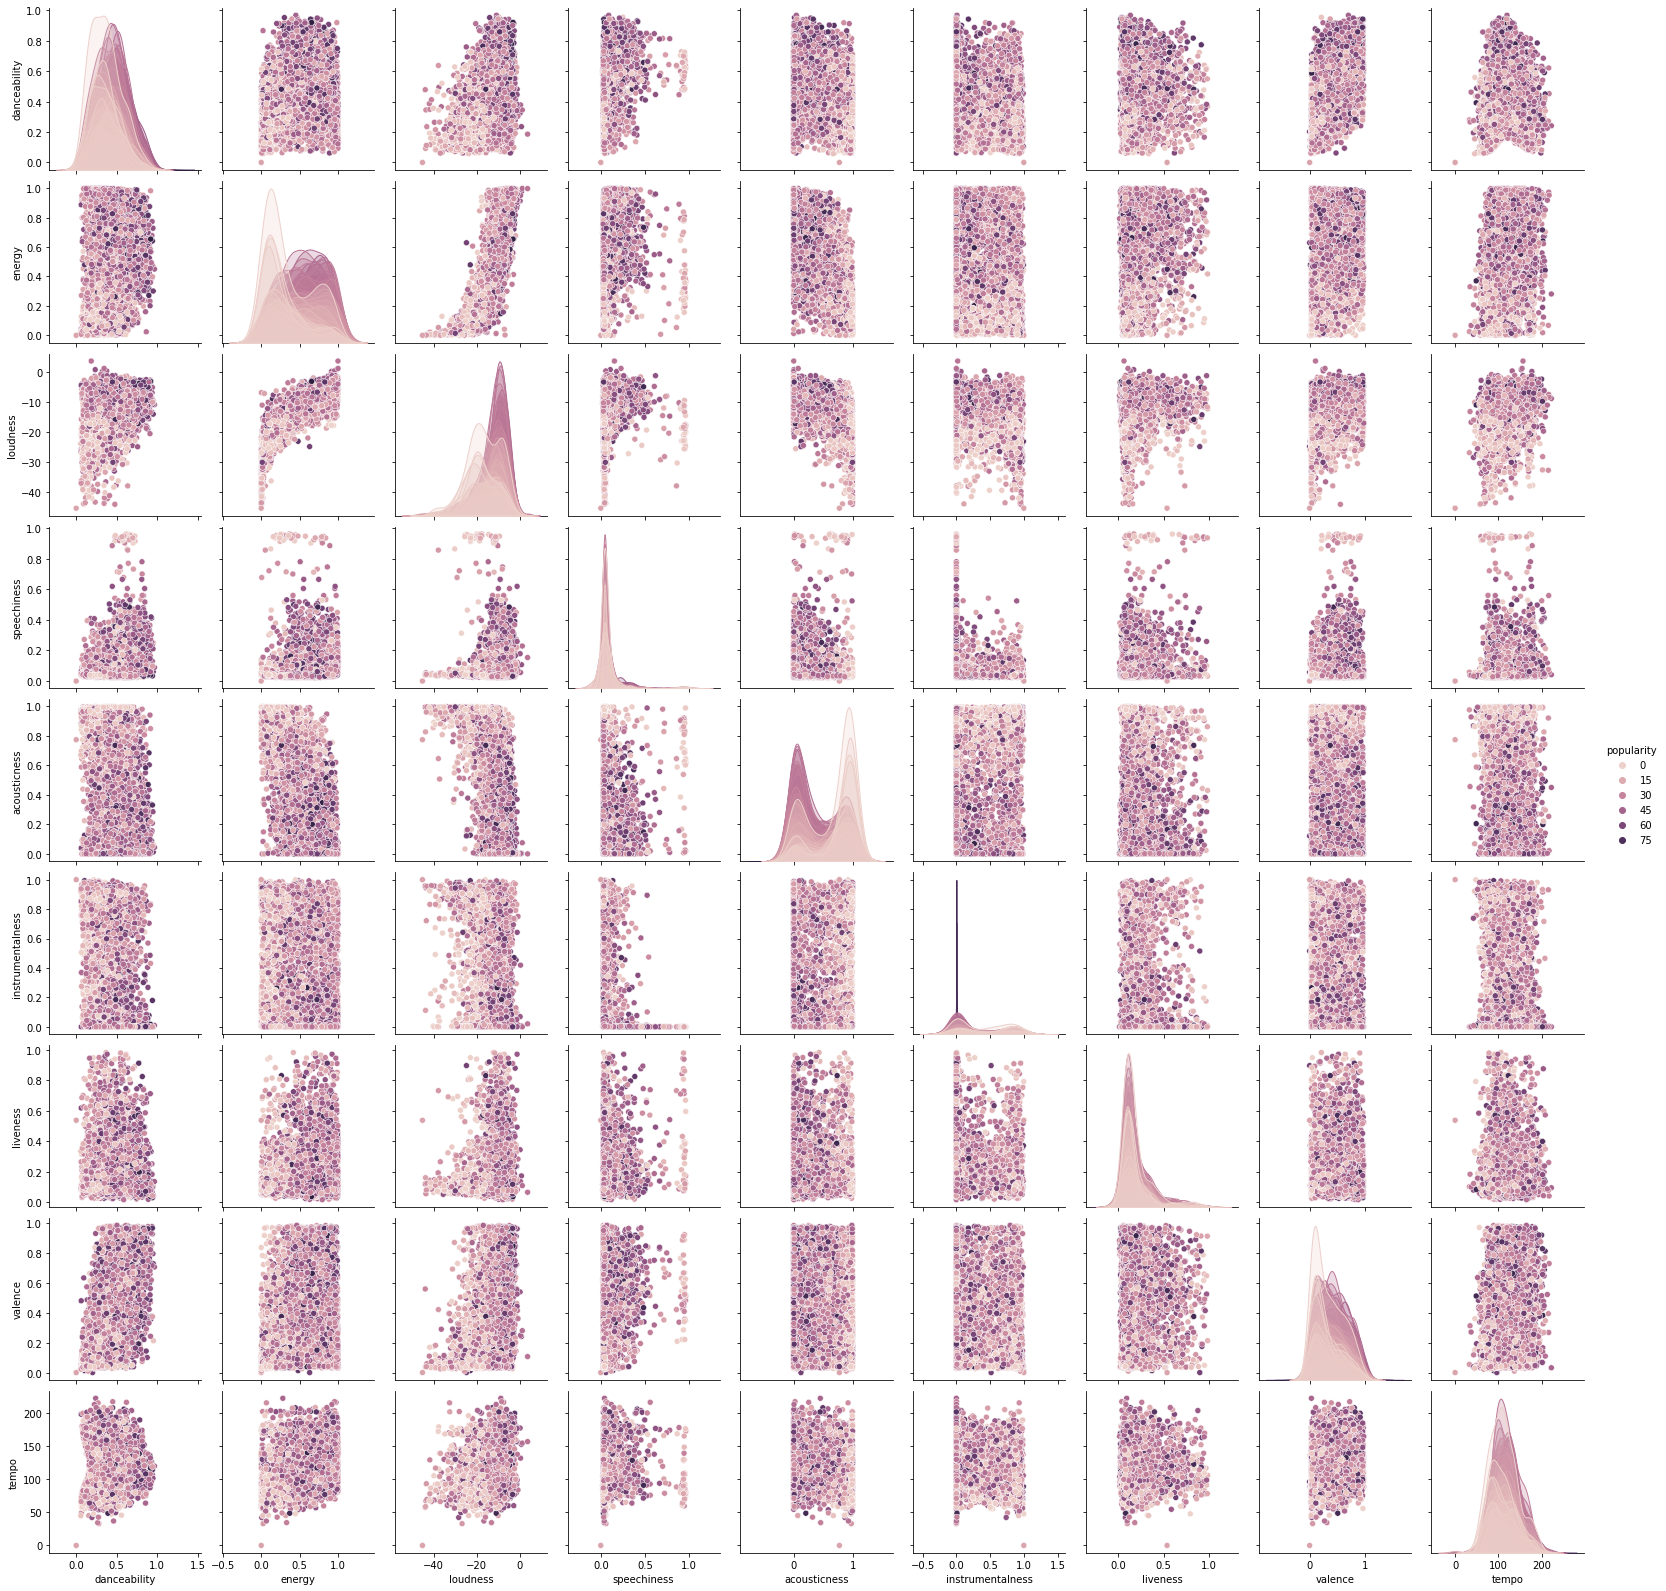

In [65]:
# plotting pair plots to analyze the relation of audio features with popularity
audio_features.append('popularity')
sn_pp = sns.pairplot(df[audio_features],hue='popularity')
sn_pp.savefig("../img/pairplot.svg")

Conclusions:

Most liked songs are:
1. Are louder
2. Have higher tempo
3. Uniformly distributed over keys
4. Are not live
5. Are nor instrumental

Also we notice that audio features `key, type, mode` are uniformly distributed and unsurprisingly, don't have any effect on the popularity

In [46]:
audio_features = [f for f in audio_features if f not in ['key', 'type', 'mode']]

[]

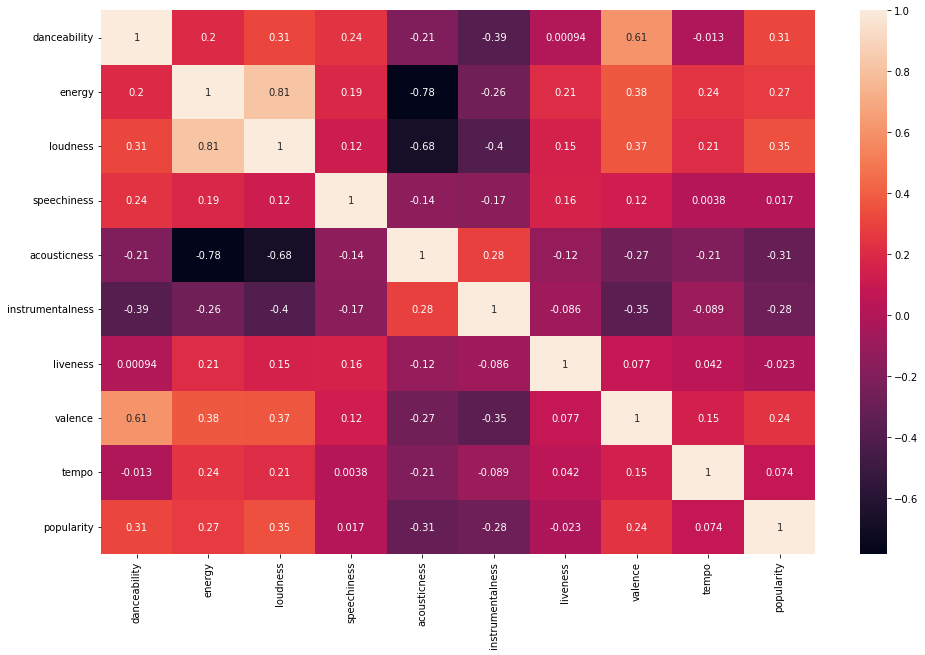

In [159]:
plt.figure(figsize=(16,10))
sns.heatmap(df[audio_features].corr(),annot=True)
plt.plot()

### K-means clustering for approximating genres

1. In the Spotify dataset each artist has a list of genres.
2. The genres have some heirarchy (sub-genres) unknown to us. eg: ['rock', 'classic j-rock', 'j-rock']
2. We make 2 assumptions here:
    1. The songs have the same genre list as those of artist - already taken care of in the `sp_genres` columns in the dataset. It is fair since the artist is the creator of the song
    2. We can map the genre list to a single genre. (justification below)
    
**Mapping Genres** <br/>
Currently, in our dataset we have 952 unique genres. These are in the form of list for each song and have heirarchy. In our attempt to discover this heirarchy, and improve visualization and modelling of our data we will map the list to a single genre.

We find the k-most popular genres and map these genre list to one of the popular genre. eg:  songs having sub-genres like 'classic j-rock', 'j-rock', 'punk-rock' all of them have 'rock' in it. <br/>

The above pairsplot shows the correlation of the audio features with the most-liked music. For the songs with popular genre we assign one of them with inverted frequency. For the songs that don't have one of the popular genre we approximate its genre from the audio features using K-means and evaluating the closest distance to the mean of features grouped by genres. Secondly, we tune the value of our hyperparameter k using elbow method.

In [6]:
# remove encoding 
# eg: '['classic j-rock', 'j-rock']' -> ['classic j-rock', 'j-rock'] (str -> List[str])
def genre_to_list(s):
    return list(map(lambda x: x.strip(' ').strip('\''), s.strip('[').strip(']').split(',')))
from collections import defaultdict
df['sp_genres'] = df['sp_genres'].apply(genre_to_list)

In [63]:
# frequencies of genres
genre_freq = defaultdict(int)
for idx, row in df.iterrows():
    for g in row['sp_genres']:
        if g != '':
            genre_freq[g] += 1

# returns the k-most popular genres
def get_k_popular_genres(d, k=20):
    return set([k for k,v in sorted(d.items(), key= lambda x: x[1],reverse=True)][:k])

pop_genres = get_k_popular_genres(genre_freq, 20)
print('Top 20 popular genres are: ', pop_genres)

# First apply genre to those songs belonging to the popular genre
def apply_genre(row):
    min_freq, curr = float('inf'), 'NA'
    for g in row:
        if g in pop_genres and genre_freq[g] < min_freq:
            curr = g
    return curr

Top 20 popular genres are:  {'permanent wave', 'alternative rock', 'hip hop', 'psychedelic rock', 'new wave', 'rock', 'classic rock', 'hard rock', 'singer-songwriter', 'folk', 'jazz', 'art rock', 'album rock', 'jazz fusion', 'classical', 'folk rock', 'metal', 'mellow gold', 'post-punk', 'experimental'}


In [84]:
df['genre'] = df['sp_genres'].apply(apply_genre)
df['genre'].describe()

count     7252
unique      19
top         NA
freq      2435
Name: genre, dtype: object

This means there is around 1/3rd of songs which don't belong to one of the major 20 genres. We try to predict. We can most closely predict the genre using a K-means clustering. 

In [73]:
Xc = df[audio_features]
Xc.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
0,0.526,0.235,-14.074,0.0991,0.907,0.000004,0.111,0.377,91.240,68
1,0.571,0.134,-14.650,0.0704,0.895,0.000000,0.111,0.459,141.231,62
2,0.562,0.213,-12.273,0.0841,0.876,0.000001,0.104,0.480,152.197,55
3,0.504,0.261,-12.577,0.0620,0.794,0.000000,0.147,0.483,145.376,52
4,0.682,0.236,-11.647,0.2490,0.844,0.000005,0.112,0.175,64.841,50


In [101]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(Xc)
Xc_scaled = scaler.transform(Xc)

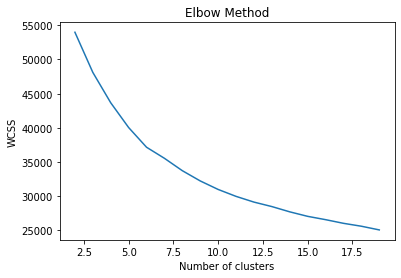

In [103]:
wcss = []
cluster_range = range(2,20,1)
for i in cluster_range:
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=RANDOM_STATE)
    kmeans.fit(Xc_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(cluster_range, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('../img/elbow.svg')
plt.show()

In [125]:
# We see that 4 clusters is the elbow for our K-means. 
# Do K-means with 4 clusters
kmeans = KMeans(n_clusters=6, max_iter=300, n_init=10, random_state=RANDOM_STATE)
kmeans.fit(Xc_scaled)

KMeans(n_clusters=6, random_state=42)

In [136]:
# Now we will find the nearest genres to these cluster labels and assign a genre to a song that doesn't have a label

def get_pop_genre_center(curr_genre):
    return df[audio_features][df['genre'] != curr_genre].mean().to_list()

pop_dict_ctrs = {}
for g in pop_genres:
    pop_dict_ctrs[g] = get_pop_genre_center(g)

# get distance of the cluster from genre
def get_dist(c, genre):
    b = np.square(np.array(pop_dict_ctrs[genre]))
    return np.sqrt(np.square(np.subtract(c, b)).sum())

cluster_ctr_genre = ['NA' for _ in range(len(kmeans.cluster_centers_))]
for idx, c in enumerate(kmeans.cluster_centers_):
    min_dist = float('inf')
    for g in pop_genres:
        curr_dist = get_dist(c, g)
        if min_dist > curr_dist:
            min_dist = curr_dist
            cluster_ctr_genre[idx] = g

def get_kmeans_genres(row):
    if row['genre'] != 'NA':
        return row['genre']
    p = row[audio_features]
    return cluster_ctr_genre[kmeans.predict([p])[0]]

genre_pred = df.apply(get_kmeans_genres, axis=1)

In [137]:
df['genre'] = genre_pred

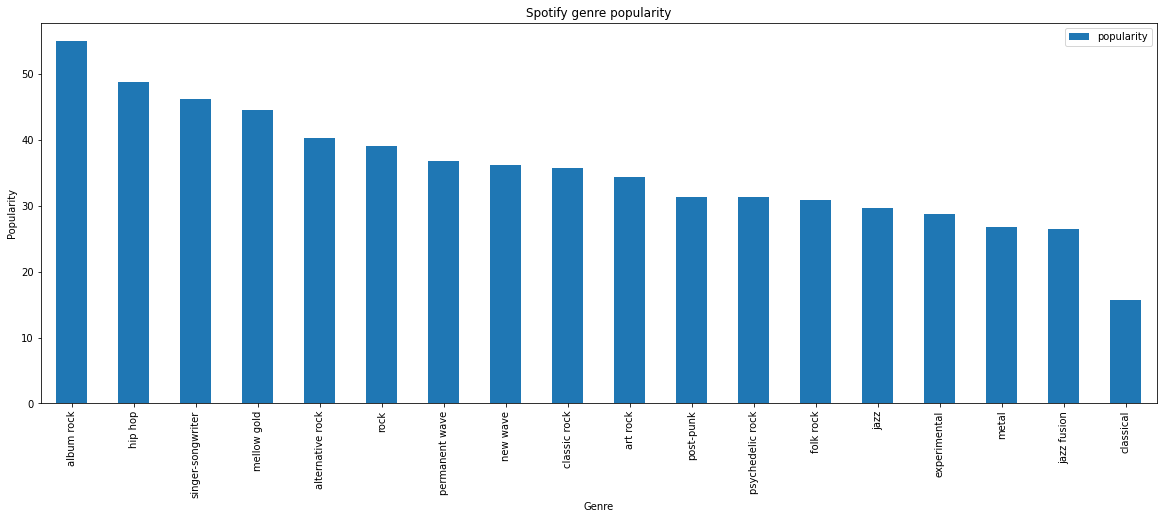

In [139]:
df_eda = df[['popularity', 'genre']]
df_eda = df_eda.groupby(['genre']).mean().sort_values('popularity', ascending=False)
# df_eda = df_eda['popularity'].sort_values

# print(df_eda['popularity'].sort_values)
df_eda.plot.bar(figsize=(20,7))
plt.xlabel('Genre')
plt.ylabel('Popularity')
plt.title("Spotify genre popularity")
plt.savefig('../img/sp_popularity.svg')
plt.show()

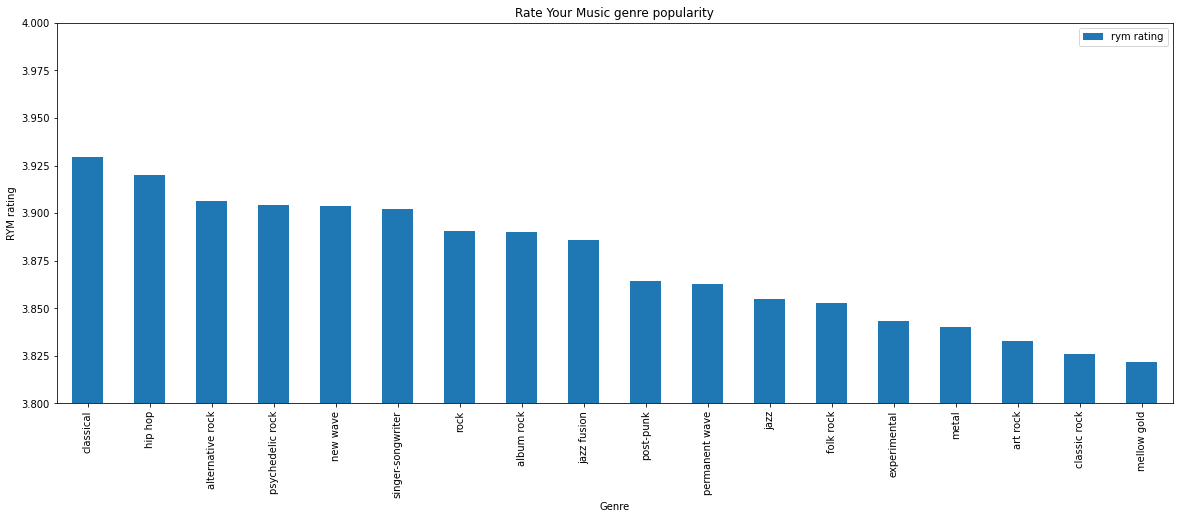

In [148]:
df_eda = df[['rym rating', 'genre']]
df_eda = df_eda.groupby(['genre']).mean().sort_values('rym rating', ascending=False)

df_eda.plot.bar(figsize=(20,7))
plt.setp(plt.gca(),ylim=(3.8, 4.0))
plt.xlabel('Genre')
plt.ylabel('RYM rating')
plt.title("Rate Your Music genre popularity")
plt.savefig('../img/rym_ratings.svg')
plt.show()

## Model & Analysis

In [4]:
# Vivek
df = pd.read_csv('../data/final-data.csv', sep='~')
x = range(3,len(df.columns)-1)
df = df.iloc[:,x]
df['rym rating'] = df['rym rating']*20
# p and (1-p ) hyperparameter tuning
df['rymspot rate'] = (df['rym rating']*.5 + df['popularity']*.5)
df['rymspot rate'].describe()
#Take average of popularity and rym rating

count    7252.000000
mean       56.457750
std         9.763336
min        37.600000
25%        49.300000
50%        56.800000
75%        63.200000
max        85.700000
Name: rymspot rate, dtype: float64

In [5]:
labels = []
for d in df['rymspot rate']:
    labels+=[0 if d >= 75 else 1 if d >= 50 else 2]

In [6]:
x = range(3,len(df.columns)-17)
X = df.iloc[:,x]
X

,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,-14.074,0,0.0991,0.90700,0.000004,0.1110,0.377,91.240
1,-14.650,1,0.0704,0.89500,0.000000,0.1110,0.459,141.231
2,-12.273,1,0.0841,0.87600,0.000001,0.1040,0.480,152.197
3,-12.577,1,0.0620,0.79400,0.000000,0.1470,0.483,145.376
4,-11.647,0,0.2490,0.84400,0.000005,0.1120,0.175,64.841
...,...,...,...,...,...,...,...,...
7247,-9.650,1,0.0443,0.00724,0.004210,0.1910,0.775,147.919
7248,-10.027,1,0.0803,0.62800,0.464000,0.0622,0.343,99.975
7249,-12.967,1,0.0284,0.86500,0.684000,0.0876,0.556,86.995
7250,-10.179,1,0.0294,0.57500,0.878000,0.0720,0.394,144.118


In [7]:
#SVM classifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('always')
X_train, X_test, y_train,y_test =train_test_split(
                                        X, labels, test_size = 0.2)
gnb = make_pipeline(StandardScaler(), SVC(gamma='auto'))
naive = gnb.fit(X_train,y_train)
y_pred = naive.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.73      0.95      0.83      1016
           2       0.62      0.20      0.31       390

    accuracy                           0.72      1451
   macro avg       0.45      0.39      0.38      1451
weighted avg       0.68      0.72      0.66      1451

[[  0  45   0]
 [  0 968  48]
 [  0 311  79]]


In [8]:
#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
naive = gnb.fit(X_train,y_train)
y_pred = naive.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.75      0.87      0.80      1016
           2       0.51      0.35      0.41       390

    accuracy                           0.70      1451
   macro avg       0.42      0.41      0.41      1451
weighted avg       0.66      0.70      0.67      1451

[[  0  45   0]
 [  0 884 132]
 [  0 254 136]]


In [15]:
#Decision Tree depth 7
from sklearn import tree
# scores = []
# for i in range(1,20):
#     # X_train, X_test, y_train,y_test =train_test_split(
#     #                                          X, labels, test_size = 0.2)
#     for x in range(1,100):
#         gnb = tree.DecisionTreeClassifier(random_state = 0, max_depth=i)
#         naive = gnb.fit(X_train,y_train)
#         y_pred = naive.predict(X_test)

#         scores += [accuracy_score(y_test, y_pred)]

#     print(sum(scores)/len(scores))
gnb = tree.DecisionTreeClassifier(random_state = 0, max_depth=7)
naive = gnb.fit(X_train,y_train)
y_pred = naive.predict(X_test)
from sklearn.tree import export_graphviz
import graphviz 
from IPython.display import display
dot_data = export_graphviz(gnb, out_file=None, feature_names = X_train.columns
                          , class_names = ['high','neutral','low'], rounded =True, filled = True)
gtree = graphviz.Source(dot_data)
display(gtree)
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

AttributeError: 'NoneType' object has no attribute 'splitlines'

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.74      0.92      0.82      1016
           2       0.55      0.26      0.35       390

    accuracy                           0.71      1451
   macro avg       0.43      0.39      0.39      1451
weighted avg       0.66      0.71      0.67      1451

[[  0  45   0]
 [  1 933  82]
 [  0 290 100]]


In [16]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

gnb = KNeighborsClassifier(n_neighbors=22)
naive = gnb.fit(X_train,y_train)
y_pred = naive.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.75      0.95      0.84      1046
           2       0.59      0.20      0.30       362

    accuracy                           0.74      1451
   macro avg       0.45      0.38      0.38      1451
weighted avg       0.69      0.74      0.68      1451

[[  0  43   0]
 [  0 995  51]
 [  0 289  73]]


In [17]:
from sklearn.neural_network import MLPClassifier

gnb = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
naive = gnb.fit(X_train,y_train)
y_pred = naive.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.72      1.00      0.84      1046
           2       0.00      0.00      0.00       362

    accuracy                           0.72      1451
   macro avg       0.24      0.33      0.28      1451
weighted avg       0.52      0.72      0.60      1451

[[   0   43    0]
 [   0 1046    0]
 [   0  362    0]]


In [18]:
#XGBoost classifier
import xgboost as xgb
boost = xgb.XGBClassifier()
bo = boost.fit(X_train,y_train)
y_pred = bo.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.05      0.09        43
           1       0.79      0.92      0.85      1046
           2       0.62      0.39      0.48       362

    accuracy                           0.76      1451
   macro avg       0.69      0.45      0.47      1451
weighted avg       0.74      0.76      0.73      1451

[[  2  40   1]
 [  1 959  86]
 [  0 220 142]]


### Recommender System

In [31]:
#Shrink df to needed features only
df = pd.read_csv('../data/final-data.csv', sep='~')
x = range(3,len(df.columns)-1)
df = df.iloc[:,x]
x = list(range(3,len(df.columns)-16))
x+=[14,-1]
X = df.iloc[:,x]
# X

In [30]:
#Edit string features into "bag of words"
import string
for r in range(len(X['sp_genres'])):
    X.iloc[r,-1] = X.iloc[r,[-1]]['sp_genres'].translate(str.maketrans('', '', string.punctuation))
# X


In [26]:
#Cosine similarity on all features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
cv = CountVectorizer()
count_matrix = cv.fit_transform(df["sp_genres"])
# print("Count Matrix:", count_matrix.toarray())
# np.shape(count_matrix)
# cosine_sim = cosine_similarity(count_matrix)
arr2 = []
np.asarray(arr2)
arr = count_matrix.toarray()
arr.astype(float)
print(len(arr))
for i in range(len(arr)):
    temp = []
    for x in range(len(X.columns)-2):
        temp += [X.iloc[i,x]]
    arr2 += [arr[i].tolist() + temp]
# len(arr2)
cosine_sim = cosine_similarity(arr2)

7252


In [29]:
#Example recommendation
namelike = 'Silent All These Years - 2015 Remaster'
def get_index_from_name(name):
    return df.index[df['name'] == name].tolist()

idx = get_index_from_name(namelike)

similar_songs = list(enumerate(cosine_sim[idx]))
songs = np.argsort(similar_songs[0][1])
topfive = songs[-2:-7:-1]
for i in range(len(topfive)):
    print(i+1,df.iloc[topfive[i]]['name'])



1 Smells Like Teen Spirit - 2015 Remaster
2 Wuthering Heights
3 L'Amour Looks Something Like You
4 The Wedding List
5 I Know


## Conclusions and Future work

In [ ]:
# Amanuel can start
# We can pitch in later